# Preprocessing

In [ ]:
from google.colab import drive # run only if runnning in colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import numpy as np
import os

# Load cleaned CFPB data (local)
# df = pd.read_csv("../data/interim/cfpb_mortgage_2024_clean.csv")

# Loan cleaned CFPB data (Colab)
colab_dir = "/content/drive/MyDrive/NLP/respect-cfpb"
df = pd.read_csv(os.path.join(colab_dir, "data/interim/cfpb_mortgage_2024_clean.csv"))

# Verify expected columns
print(df.columns)

# Create binary risk flag
RISKY = {"Closed with monetary relief", "Closed with non-monetary relief"}
df["risk_flag"] = df["company_response"].isin(RISKY).astype(int)

# Drop rows with missing or empty narratives
df = df[df["clean_text"].notna() & (df["clean_text"].str.strip() != "")]

# Check class balance
print(df["risk_flag"].value_counts(normalize=True))
print(df["risk_flag"].value_counts())

# First split: train (60%) vs temp (40%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df["risk_flag"],
    random_state=42
)

# Second split: validation (20%) and test (20%) from temp
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["risk_flag"],
    random_state=42
)

# Confirm split sizes and balance
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train risk ratio:", train_df["risk_flag"].mean())
print("Val risk ratio:", val_df["risk_flag"].mean())
print("Test risk ratio:", test_df["risk_flag"].mean())

# Save splits to data/splits folder (local)
# os.makedirs("../data/processed", exist_ok=True)
# train_df.to_csv("../data/processed/train.csv", index=False)
# val_df.to_csv("../data/processed/val.csv", index=False)
# test_df.to_csv("../data/processed/test.csv", index=False)

# Save splits to data/splits folder (colab)
processed_dir = os.path.join(colab_dir, "data/processed")
os.makedirs(processed_dir, exist_ok=True)
train_df.to_csv(os.path.join(processed_dir, "train.csv"), index=False)
val_df.to_csv(os.path.join(processed_dir, "val.csv"), index=False)
test_df.to_csv(os.path.join(processed_dir, "test.csv"), index=False)

Index(['complaint_id', 'date_received', 'company', 'issue', 'sub_product',
       'clean_text', 'word_len', 'company_response', 'timely', 'state',
       'month'],
      dtype='object')
risk_flag
0    0.951168
1    0.048832
Name: proportion, dtype: float64
risk_flag
0    11239
1      577
Name: count, dtype: int64
Train: 7089 Val: 2363 Test: 2364
Train risk ratio: 0.048808012413598535
Val risk ratio: 0.048666948793906054
Test risk ratio: 0.049069373942470386


# Baseline Model: TF-IDF

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-split data (local)
# train_df = pd.read_csv("../data/processed/train.csv")
# val_df = pd.read_csv("../data/processed/val.csv")
# test_df = pd.read_csv("../data/processed/test.csv")

# Load pre-split data (Colab)
train_df = pd.read_csv(os.path.join(colab_dir, "data/processed/train.csv"))
val_df = pd.read_csv(os.path.join(colab_dir, "data/processed/val.csv"))
test_df = pd.read_csv(os.path.join(colab_dir, "data/processed/test.csv"))

# Extract features and labels
X_train, y_train = train_df["clean_text"], train_df["risk_flag"]
X_val, y_val = val_df["clean_text"], val_df["risk_flag"]
X_test, y_test = test_df["clean_text"], test_df["risk_flag"]

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=50000,   # vocabulary cap for efficiency
    ngram_range=(1,1),     # unigrams and bigrams
    stop_words='english',
    min_df=5               # ignore rare tokens
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression model with class weighting
model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="liblinear",
    C=0.01,
    random_state=42
)

# Train the model
model.fit(X_train_tfidf, y_train)

# Evaluate generalization between training and validation
y_train_pred = model.predict(X_train_tfidf)
y_train_prob = model.predict_proba(X_train_tfidf)[:, 1]

y_val_pred = model.predict(X_val_tfidf)
y_val_prob = model.predict_proba(X_val_tfidf)[:, 1]

print("Training Results")
print(classification_report(y_train, y_train_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))

print("\nValidation Results")
print(classification_report(y_val, y_val_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))


Training Results
              precision    recall  f1-score   support

           0      0.987     0.828     0.901      6743
           1      0.190     0.786     0.306       346

    accuracy                          0.826      7089
   macro avg      0.588     0.807     0.603      7089
weighted avg      0.948     0.826     0.872      7089

ROC-AUC: 0.8902199154936097

Validation Results
              precision    recall  f1-score   support

           0      0.977     0.811     0.886      2248
           1      0.147     0.635     0.238       115

    accuracy                          0.802      2363
   macro avg      0.562     0.723     0.562      2363
weighted avg      0.937     0.802     0.855      2363

ROC-AUC: 0.8033614420547733


Test Results
              precision    recall  f1-score   support

           0      0.973     0.799     0.878      2248
           1      0.129     0.578     0.211       116

    accuracy                          0.788      2364
   macro avg      0.551     0.688     0.544      2364
weighted avg      0.932     0.788     0.845      2364

ROC-AUC: 0.7852228801079887


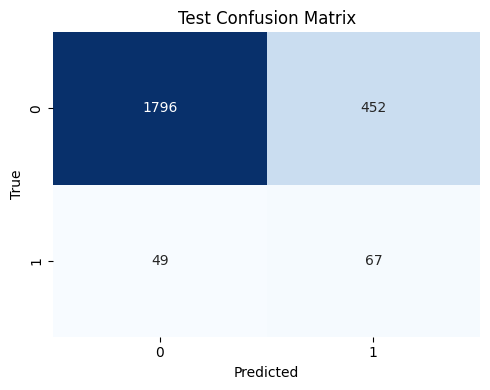

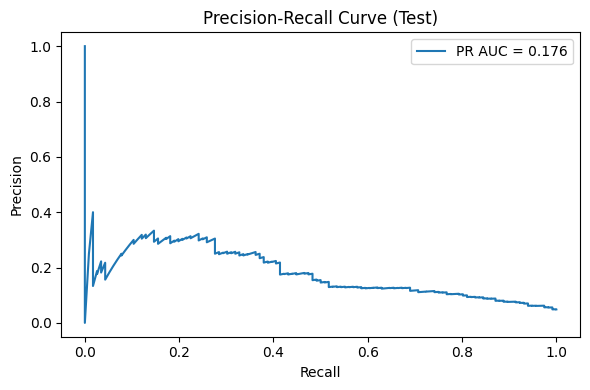

In [ ]:
# Predict on test set
test_preds = model.predict(X_test_tfidf)
test_probs = model.predict_proba(X_test_tfidf)[:, 1]

# Print performance report
print("Test Results")
print(classification_report(y_test, test_preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, test_probs))

# Confusion matrix
cm_test = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, test_probs)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Save results for later
baseline_results = {
    "model_name": "tfidf_logreg_baseline",
    "performance": {
        "test": {
            "roc_auc": float(roc_auc_score(y_test, test_probs)),
            "precision_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['precision'], 3)),
            "recall_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['recall'], 3)),
            "f1_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['f1-score'], 3)),
            "accuracy": float(np.round(classification_report(y_test, test_preds, output_dict=True)['accuracy'], 3))
        }
    }
}

# Create output folder
os.makedirs("../outputs/models", exist_ok=True)

# Save as JSON
output_path = "../outputs/models/baseline_tfidf_logreg_results.json"
with open(output_path, "w") as f:
    json.dump(baseline_results, f, indent=4)

# Improved Model: FinBERT & LoRA

## Load FinBERT

In [ ]:
import os
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Load data (local)
# train_df = pd.read_csv("../data/processed/train.csv")
# val_df   = pd.read_csv("../data/processed/val.csv")
# test_df  = pd.read_csv("../data/processed/test.csv")

# Load pre-split data (Colab)
train_df = pd.read_csv(os.path.join(colab_dir, "data/processed/train.csv"))
val_df = pd.read_csv(os.path.join(colab_dir, "data/processed/val.csv"))
test_df = pd.read_csv(os.path.join(colab_dir, "data/processed/test.csv"))

# Initiate and load tokenizer for FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df[["clean_text", "risk_flag"]]).rename_column("risk_flag", "labels")
val_dataset   = Dataset.from_pandas(val_df[["clean_text", "risk_flag"]]).rename_column("risk_flag", "labels")
test_dataset  = Dataset.from_pandas(test_df[["clean_text", "risk_flag"]]).rename_column("risk_flag", "labels")

# Tokenize input text
def tokenize_function(examples):
    return tokenizer(
        examples["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["clean_text"])
val_dataset   = val_dataset.map(tokenize_function, batched=True, remove_columns=["clean_text"])
test_dataset  = test_dataset.map(tokenize_function, batched=True, remove_columns=["clean_text"])

# Load FinBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2, # Set number of labels to 2 (risk, no risk)
    ignore_mismatched_sizes=True # since we are changing the num of labels
).to(device)

device: cuda


Map:   0%|          | 0/7089 [00:00<?, ? examples/s]

Map:   0%|          | 0/2363 [00:00<?, ? examples/s]

Map:   0%|          | 0/2364 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Class balancing
To address the class imbalance in our dataset, we apply a weighted cross-entropy loss function.
This technique rebalances the contribution of each class during training by assigning higher weights to the minority class (“risk”), which comprises only ~5% of the complaints.

Following the approach described in
* “Addressing Data Imbalance in Transformers” ([arXiv:2507.11384v1](https://arxiv.org/html/2507.11384v1)), and
* “Baseline with HuggingFace” ([Inagana, Kaggle, 2023](https://www.kaggle.com/code/inagana/baseline-with-huggingface-training-beginners)),

In [ ]:
from torch.nn import CrossEntropyLoss
import torch

# Compute class weights from train_df
counts = train_df["risk_flag"].value_counts()
n_total = len(train_df)

# inverse frequency weighting to give rare classes higher weights
weight_for_0 = n_total / counts[0]
weight_for_1 = n_total / counts[1] * 2 # increasing the weight for risk flag

# convert to tensor and push to device
class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float).to(device)
print("Class Weights:", class_weights)

# Define a weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Class Weights: tensor([ 1.0513, 40.9769], device='cuda:0')


## LoRA Fine-Tuning
Source: W266 Walkthrough Notebook for Lora

In [ ]:
!pip install -q evaluate>=0.4.2

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer,TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import evaluate


# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none"
)
# Inject LoRA adapters into FinBERT
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


In [ ]:
# Evaluation function
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="binary")["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="binary")["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
# set up training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/respect-cfpb/models/finbert_lora",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=25,
    report_to="none",
    gradient_accumulation_steps=2,
    seed=42,
    metric_for_best_model="f1",
    greater_is_better=True
)

In [ ]:
# Train model with the custom trainer with the weighted cross-entropy loss function
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

/tmp/ipython-input-72509324.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.387800,0.711568,0.938214,0.355140,0.330435,0.342342
2,0.404800,0.703278,0.939061,0.359223,0.321739,0.339450
3,0.419000,0.697699,0.939061,0.359223,0.321739,0.339450


TrainOutput(global_step=1332, training_loss=0.5056971365267092, metrics={'train_runtime': 399.4268, 'train_samples_per_second': 53.244, 'train_steps_per_second': 3.335, 'total_flos': 5614950552145920.0, 'train_loss': 0.5056971365267092, 'epoch': 3.0})

              precision    recall  f1-score   support

           0      0.965     0.964     0.965      2248
           1      0.319     0.328     0.323       116

    accuracy                          0.933      2364
   macro avg      0.642     0.646     0.644      2364
weighted avg      0.934     0.933     0.933      2364

ROC-AUC: 0.798


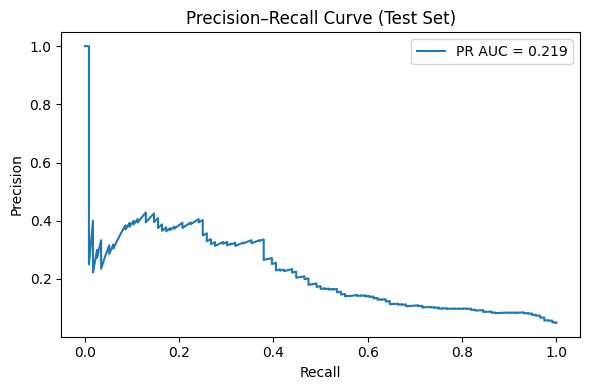

In [ ]:
from sklearn.metrics import auc as sk_auc
# Load the best model automatically restored from training
best_model = trainer.model

# Get predictions on test set
predictions = trainer.predict(test_dataset)
pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = np.array(predictions.label_ids)

# Evaluate metrics
roc_auc = roc_auc_score(true_labels, pred_probs)
report = classification_report(true_labels, pred_labels, digits=3)
print(report)
print("ROC-AUC:", round(roc_auc, 3))

# Plot Precision–Recall curve
prec, rec, _ = precision_recall_curve(true_labels, pred_probs)
pr_auc = sk_auc(rec, prec)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Save metrics for comparison
import os, json
os.makedirs("/content/drive/MyDrive/NLP/respect-cfpb/outputs/models", exist_ok=True)

test_results = {
    "model_name": "finbert_lora_weighted",
    "performance": {
        "test": {
            "roc_auc": float(round(roc_auc, 3)),
            "precision_risk": float(np.round(classification_report(true_labels, pred_labels, output_dict=True)['1']['precision'], 3)),
            "recall_risk": float(np.round(classification_report(true_labels, pred_labels, output_dict=True)['1']['recall'], 3)),
            "f1_risk": float(np.round(classification_report(true_labels, pred_labels, output_dict=True)['1']['f1-score'], 3)),
            "accuracy": float(np.round(classification_report(true_labels, pred_labels, output_dict=True)['accuracy'], 3))
        }
    }
}

output_path = "/content/drive/MyDrive/NLP/respect-cfpb/outputs/models/finbert_lora_results.json"
with open(output_path, "w") as f:
    json.dump(test_results, f, indent=4)

print(f"Test results saved to {output_path}")

Test results saved to /content/drive/MyDrive/NLP/respect-cfpb/outputs/models/finbert_lora_results.json


## Complaint Early Warning Model

# Validation and Comparison of Baseline and Improved Models